# <span style="color: orange;">Modélisation </span>

Modèle recursif juste pour tester.

Avant ça, faire le feature engineering.

Année max : 2011
Coupure : Train <= 2009 | Validation > 2009
Dimensions Train : (6842, 35)
Dimensions Valid : (2288, 35)

--- RÉSULTATS SUR LES 2 DERNIÈRES ANNÉES ---
RMSE : 76.18
MAE  : 35.10


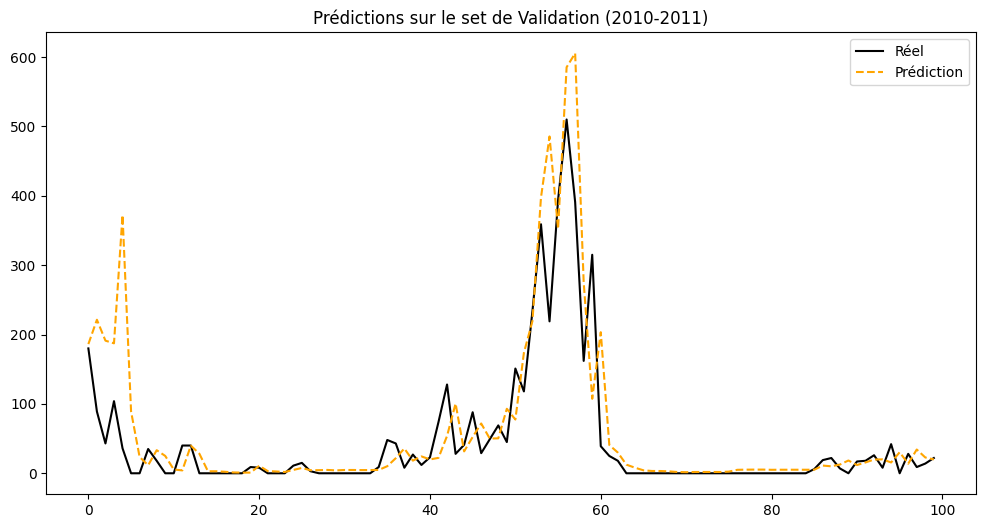


Top 5 Variables Importantes :
Taux_Lag1         0.724218
week_num          0.058669
Taux_Lag2         0.050409
Taux_Rolling3     0.032911
requete_grippe    0.022499
dtype: float64


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Chargement et Tri
df = pd.read_csv('../data/processed/train_final.csv')

# Extraction de l'année et du numéro de semaine depuis 'week' (ex: 201152)
df['year'] = df['week'].astype(str).str[:4].astype(int)
df['week_num'] = df['week'].astype(str).str[4:].astype(int)

# --- CRUCIAL : TRIER LES DONNÉES ---
# Pour que les décalages (lags) soient cohérents, il faut trier par Région puis par Temps
df = df.sort_values(by=['region_name', 'year', 'week_num'])

# 2. Feature Engineering Spécial Panel
# On crée les "Lags" : La grippe de la semaine dernière (t-1) prédit celle de cette semaine (t)
# Le .groupby('region_name') est vital pour ne pas mélanger les régions entre elles !
df['Taux_Lag1'] = df.groupby('region_name')['TauxGrippe'].shift(1)
df['Taux_Lag2'] = df.groupby('region_name')['TauxGrippe'].shift(2)

# On peut aussi faire une moyenne mobile sur 3 semaines (lissage)
df['Taux_Rolling3'] = df.groupby('region_name')['Taux_Lag1'].transform(lambda x: x.rolling(3).mean())

# On supprime les premières lignes qui contiennent des NaN à cause du décalage
df_model = df.dropna().copy()

# 3. Encodage de la variable catégorielle 'region_name'
df_encoded = pd.get_dummies(df_model, columns=['region_name'], drop_first=True)

# 4. Division Train / Validation (2 dernières années)
# On identifie l'année max
max_year = df_encoded['year'].max()
split_cutoff = max_year - 2  # On garde les 2 dernières années pour la valid

print(f"Année max : {max_year}")
print(f"Coupure : Train <= {split_cutoff} | Validation > {split_cutoff}")

# Sélection des features (tout sauf la cible et les ID/dates brutes)
target = 'TauxGrippe'
cols_to_drop = [target, 'Id', 'week', 'week_date', 'month_date', 'month'] 
# On garde 'year' et 'week_num' car ce sont des entiers utiles, mais on retire les formats dates s'ils existent
features = [col for col in df_encoded.columns if col not in cols_to_drop]

# SPLIT
X_train = df_encoded[df_encoded['year'] <= split_cutoff][features]
y_train = df_encoded[df_encoded['year'] <= split_cutoff][target]

X_val = df_encoded[df_encoded['year'] > split_cutoff][features]
y_val = df_encoded[df_encoded['year'] > split_cutoff][target]

print(f"Dimensions Train : {X_train.shape}")
print(f"Dimensions Valid : {X_val.shape}")

# 5. Entraînement
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# 6. Évaluation
preds = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, preds))
mae = mean_absolute_error(y_val, preds)

print(f"\n--- RÉSULTATS SUR LES 2 DERNIÈRES ANNÉES ---")
print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")

# 7. Visualisation des prédictions (Zoom sur les 100 premières semaines du set de validation)
plt.figure(figsize=(12, 6))
plt.plot(y_val.values[:100], label='Réel', color='black')
plt.plot(preds[:100], label='Prédiction', color='orange', linestyle='--')
plt.title(f"Prédictions sur le set de Validation ({max_year-1}-{max_year})")
plt.legend()
plt.show()

# Importance des variables
import pandas as pd
importance = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
print("\nTop 5 Variables Importantes :")
print(importance.head(5))

In [4]:
import pandas as pd
import numpy as np

# Load Data
train_df = pd.read_csv('../data/processed/train_final.csv')
test_df = pd.read_csv('../data/processed/test.csv')

# Inspect Train
print("--- TRAIN ---")
print(f"Weeks: {train_df['week'].min()} to {train_df['week'].max()}")
print(f"Shape: {train_df.shape}")

# Inspect Test
print("\n--- TEST ---")
print(f"Weeks: {test_df['week'].min()} to {test_df['week'].max()}")
print(f"Shape: {test_df.shape}")
print(f"Columns: {test_df.columns.tolist()}")

# Check if regions are the same
train_regions = set(train_df['region_name'].unique())
test_regions = set(test_df['region_name'].unique())
print(f"\nRegions diff: {train_regions.symmetric_difference(test_regions)}")

# Check for temporal gap
max_train_week = train_df['week'].max()
min_test_week = test_df['week'].min()
print(f"\nMax Train Week: {max_train_week}")
print(f"Min Test Week: {min_test_week}")

--- TRAIN ---
Weeks: 200401 to 201152
Shape: (9196, 17)

--- TEST ---
Weeks: 201201 to 201352
Shape: (2288, 12)
Columns: ['Id', 'week', 'region_name', 'pop_0_19', 'pop_20_39', 'pop_40_59', 'pop_60_74', 'pop_75_plus', 'pop_total', 'requete_grippe', 'requete_grippe_aviaire_vaccin', 'requete_grippe_aviaire_vaccin_porcine_porc_H1N1_AH1N1_A_mexicaine_Mexique_pandemie']

Regions diff: set()

Max Train Week: 201152
Min Test Week: 201201


In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# 1. Load Data
train_df = pd.read_csv('../data/processed/train_final.csv')
test_df = pd.read_csv('../data/processed/test.csv')

# 2. Combine Data
# Add empty target to test
test_df['TauxGrippe'] = np.nan
# Concatenate
df = pd.concat([train_df, test_df], ignore_index=True)

# 3. Preprocessing (Common to Train & Test)
df['year'] = df['week'].astype(str).str[:4].astype(int)
df['week_num'] = df['week'].astype(str).str[4:].astype(int)

# Sort strictly by Region then Time for shift
df = df.sort_values(by=['region_name', 'week'])

# One-Hot Encoding for Region (needed for model)
df_encoded = pd.get_dummies(df, columns=['region_name'], drop_first=True) # Keep columns for reference if needed, but get_dummies usually removes them
# Wait, get_dummies removes the original column. I need 'region_name' for grouping in the loop. 
# Better: encode separately or keep a copy.
# Let's keep a 'region_id' or just use the dummies.
# Actually, for the loop 'groupby', I can rely on the index or just re-infer.
# Let's create dummies but keep 'region_name' in a separate variable if lost, or just join it back.
# Simplest: Just use `pd.get_dummies(..., prefix='region')` and keep the logic simple.
# I'll perform encoding *inside* the loop? No, that's inefficient.
# I will create a separate 'features' dataframe for training, but keep 'df' with 'region_name' for shifting.

# Let's define the Feature Columns
# Exclude non-feature cols
exclude_cols = ['Id', 'week', 'week_date', 'month_date', 'month', 'TauxGrippe', 'region_name']
# We need to identify dummy columns.
dummy_df = pd.get_dummies(df['region_name'], prefix='region', drop_first=True)
df = pd.concat([df, dummy_df], axis=1)

# List of feature columns (excluding Lags for now, we'll add them)
static_features = [c for c in df.columns if c not in exclude_cols and c not in dummy_df.columns and c != 'region_name'] + list(dummy_df.columns)
# static_features are: pop_..., requete_..., year, week_num, region_ALSACE, ...

# 4. Initial Lag Creation (for Train set mostly)
# We calculate lags on the whole DF. For Test rows, Lag1 will be NaN initially (except the first week 201201 which looks at 201152).
# Actually, shift(1) for 201201 *will* find 201152 value because we sorted. So 201201 is ready to be predicted!
df['Taux_Lag1'] = df.groupby('region_name')['TauxGrippe'].shift(1)
df['Taux_Lag2'] = df.groupby('region_name')['TauxGrippe'].shift(2)

# 5. Train the Model
# We train on all rows where TauxGrippe is NOT NaN (i.e., the Train set)
# We also need to drop rows where Lags are NaN (the very first weeks of 2004)
train_rows = df.dropna(subset=['TauxGrippe', 'Taux_Lag1', 'Taux_Lag2'])

features = [c for c in train_rows.columns if c not in ['Id', 'week', 'TauxGrippe', 'region_name', 'week_date', 'month', 'month_date']]
target = 'TauxGrippe'

print(f"Training on {len(train_rows)} rows...")
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(train_rows[features], train_rows[target])
print("Model trained.")

# 6. Recursive Prediction Loop
# Get all test weeks sorted
test_weeks = sorted(test_df['week'].unique())

print(f"Starting recursive prediction for {len(test_weeks)} weeks...")

for w in test_weeks:
    # A. Update Lags for the current week 'w'
    # We only really need to update the rows for week 'w'.
    # But to be safe and simple, we can update globally or locally.
    # Global update is safest but slow. 
    # Optimization: We only need to compute shift for the rows of week 'w'.
    # Lag1 of week 'w' is Taux of week 'w-1'.
    # Since we sorted by region/week, we can just use shift().
    # Note: df is ALREADY sorted.
    
    # We must RE-CALCULATE lags because TauxGrippe for previous test weeks has been filled in the previous iteration!
    df['Taux_Lag1'] = df.groupby('region_name')['TauxGrippe'].shift(1)
    df['Taux_Lag2'] = df.groupby('region_name')['TauxGrippe'].shift(2)
    
    # B. Identify rows to predict (Current Week)
    # We need rows where week == w
    current_mask = (df['week'] == w)
    
    # C. Predict
    # We use the features for these rows
    X_current = df.loc[current_mask, features]
    
    # Check if we have NaNs (should not happen if logic is correct, except maybe Lag2 for first weeks?)
    # For 201201: Lag1 is 201152 (OK), Lag2 is 201151 (OK).
    # So X_current should be clean.
    if X_current.isnull().any().any():
        print(f"Warning: NaNs found in features for week {w}. Filling with 0.")
        X_current = X_current.fillna(0)
        
    y_pred = model.predict(X_current)
    
    # D. Update DataFrame with Predictions
    # This is the crucial step: Filling the 'TauxGrippe' allows the next iteration's shift() to pick it up.
    df.loc[current_mask, 'TauxGrippe'] = y_pred

print("Prediction complete.")

# 7. Extract Submission
# We take only the rows from the original test set
submission = df[df['week'].isin(test_weeks)][['Id', 'TauxGrippe']]
# Ensure integer ID
submission['Id'] = submission['Id'].astype(int)
# Sort by ID to match sample_submission format usually
submission = submission.sort_values('Id')

# Save
submission.to_csv('../results/submissions/submission_flu.csv', index=False)
print(f"Submission saved: {submission.shape}")
print(submission.head())

Training on 9152 rows...
Model trained.
Starting recursive prediction for 104 weeks...
Prediction complete.
Submission saved: (2288, 2)
        Id  TauxGrippe
9196  3235       57.75
9197  3236       35.55
9198  3237       59.26
9199  3238       50.04
9200  3239       46.63
